In [14]:
#game_1 : "find_this_mii"

import cv2, time
import numpy as np

#將滑鼠移動的軌跡繪製成方框
def mouse_callback(event, _x, _y, flags, param):
    global show_img, x0, y0, w, h, mouse_pressed
    if event == cv2.EVENT_LBUTTONDOWN:
        mouse_pressed = True
        x0, y0 = _x, _y
        show_img = np.copy(frame0)
    elif event == cv2.EVENT_MOUSEMOVE:
        if mouse_pressed:
            show_img = np.copy(frame0)
            cv2.rectangle(show_img, (x0, y0), (_x, _y), (0, 255, 0), 2)
    elif event == cv2.EVENT_LBUTTONUP:
        mouse_pressed = False
        w, h = _x - x0, _y - y0

scaling_factor = 1

# 1A. WiiPlay.mp4 with level 15(frame number between 4820 and 5000).
cap = cv2.VideoCapture("wiiplay.mp4")
frame_seq = 4820
cap.set(cv2.CAP_PROP_POS_FRAMES , frame_seq)
status_cap, frame0 = cap.read()
#print(frame0.shape)

# 2B. Acquire a face template from the first frame (frame number = 4820).
show_img = np.copy(frame0)
mouse_pressed = False
y0 = x0 = w = h = 0
#將影格傳入函數，繪製方框，並記錄標記被人臉的座標
cv2.namedWindow('image')
cv2.setMouseCallback('image', mouse_callback)
while True:
    cv2.imshow('image', show_img)
    k = cv2.waitKey(1)
    if k == ord('a') and not mouse_pressed:
        if w*h > 0:
            break
cv2.destroyAllWindows()
#取出標記出的人臉區域
template2 = np.copy(frame0[y0:y0+h, x0:x0+w])
#cv2.imshow('template',template2)
template = np.copy(frame0[345:460, 600:680])
h,w = template.shape[:2]
#cv2.imshow("img",frame0)
#cv2.imshow('template2',template)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 1C. (10pts) Try to detect the face the same as the template on subsequent frames,
# draw a red rectangle around the detected face, and show the output images in the "find_this_mii" window.
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR','cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
select = 1
while True:
    frame_seq += 1
    if frame_seq > 5000:
        frame_seq = 4820
        cap.set(cv2.CAP_PROP_POS_FRAMES , frame_seq)
    status_cap, frame0 = cap.read()
    if not status_cap:
        break
    show_img = cv2.resize(frame0, None, fx=scaling_factor, fy=scaling_factor)
    k = cv2.waitKey(1)
    if k == -1:
        k = select
    else:
        if k == 27:  #ESC鍵
            break
        k = int(chr(k))
        select = k
    if k == 27:  #ESC鍵
        break
    elif k >= 0:
        index = k
        if 0 <= index < len(methods):
            method = methods[index] # cv2.TM_CCOEFF_NORMED
            res = cv2.matchTemplate(show_img, template, eval(method))
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
            if eval(method) in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
                top_left = (min_loc[0], min_loc[1])
            else:
                top_left = (max_loc[0], max_loc[1])
            bottom_right = (top_left[0] + w, top_left[1] + h)
            res = cv2.normalize(res, None, 0, 1, cv2.NORM_MINMAX)      #正規化到0~1區間 
            res_img = np.copy(res)
            res_img = cv2.cvtColor(res_img, cv2.COLOR_GRAY2BGR).astype(np.uint8)
            
            if eval(method) in [cv2.TM_CCOEFF, cv2.TM_CCOEFF_NORMED]:
                flage = 1
                val,result = cv2.threshold(res,0.95,1.0,cv2.THRESH_BINARY)
                #cv2.imshow('result',result)
                match_locs = cv2.findNonZero(result)
            elif eval(method) in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
                flage = 1
                val,result = cv2.threshold(res,0.01,1.0,cv2.THRESH_BINARY_INV)
                #cv2.imshow('res',res)
                #cv2.imshow('result',result)
                match_locs = cv2.findNonZero(result)
            else:
                #cv2.imshow('res',res)
                flage = 0
                for y in range(0, res.shape[0]):
                    for x in range(0, res.shape[1]):
                        if (index >= methods.index('cv2.TM_SQDIFF')) and (res[y,x] < 0.1):            
                            cv2.rectangle(res_img, (x - int(w/2), y - int(h/2)), (x + int(w/2), y + int(h/2)),(255, 0, 0), 3, 8, 0)
                        elif (index < methods.index('cv2.TM_SQDIFF')) and (res[y,x] > 0.95):
                            cv2.rectangle(res_img, (x - int(w/2), y - int(h/2)), (x + int(w/2), y + int(h/2)),(255, 0, 0), 3, 8, 0)
                            #print((x - int(w/2), y - int(h/2)))
                            #print('res[y,x]',res[y,x])
            
            
            cv2.rectangle(res_img, top_left,  bottom_right, (0, 0, 255), 3, 8, 0)
            cv2.putText(show_img, method, (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3, 8, 0)
            cv2.rectangle(show_img,top_left, bottom_right, (0, 0, 255), 2)
            #show_img = np.hstack((show_img, res_img)) # 在右邊水平並排顯示視窗
            #cv2.imshow('tm2', res_img)
            cv2.imshow('find_this_mii', show_img)
cap.release()
cv2.destroyAllWindows()

In [155]:
#game_2 : "find_two_look_alike"

import cv2
import numpy as np

# 2A. Input images from video file WiiPlay.mp4 with level 8 (frame number between 2180 and 2380).
scaling_factor = 0.75
cap = cv2.VideoCapture("wiiplay.mp4")
frame_seq = 2180

# 2B. (5pts) Detect pedestrians on each frame and draw a green rectangle around your detection.
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# 2C. (5pts) Detect faces on each frame and draw a blue rectangle around your detection.
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

while True:
    frame_seq += 1
    if frame_seq > 2380:
        frame_seq = 2180
    cap.set(cv2.CAP_PROP_POS_FRAMES , frame_seq)
    status_cap, frame0 = cap.read()
    if not status_cap:
        break
    frame = cv2.resize(frame0, None, fx=scaling_factor, fy=scaling_factor)
    if frame_seq > 2210:
        locations, weights = hog.detectMultiScale(frame, winStride=(16,4), groupThreshold = 1.0,scale = 1.03,padding = (16,16))
        dect_list = []
        for loc in locations:
            dect_list.append((loc[0], loc[1],loc[2], loc[3]))
            cv2.rectangle(frame, (loc[0], loc[1]),(loc[0]+loc[2], loc[1]+loc[3]), (0, 255, 0), 3)

        # face_cascade.detectMultiScale: minNeighbors出現幾次才確定是臉
        face_rects = face_cascade.detectMultiScale(frame, scaleFactor=1.03, minNeighbors=1,minSize=(40,40))
        for (x,y,w,h) in face_rects:
            if w < 60 and w > 40:
                cv2.rectangle(frame, (x,y), (x+w,y+h), (255,0,0), 3)
    cv2.imshow("find_two_look_alike", frame)
    k = cv2.waitKey(1)
    if k == 27 :
        break
        
cap.release()
cv2.destroyAllWindows()

In [35]:
#game_3 : "find_the_fastest_character"

import cv2
import numpy as np

scaling_factor = 1
cap = cv2.VideoCapture("wiiplay.mp4")
frame_seq = 2480

while True:
    frame_seq += 1
    if frame_seq > 2600:
        frame_seq = 2480
    cap.set(cv2.CAP_PROP_POS_FRAMES , frame_seq)
    status_cap, frame0 = cap.read()
    if not status_cap:
        break
    frame = cv2.resize(frame0, None, fx=scaling_factor, fy=scaling_factor)
    
    cv2.imshow("find_the_fastest_character", frame)
    k = cv2.waitKey(1)
    if k == 27:
        break
        
cap.release()
cv2.destroyAllWindows()

In [36]:
#game_4 : "find_two_odds"

import cv2
import numpy as np

scaling_factor = 1
cap = cv2.VideoCapture("wiiplay.mp4")
frame_seq = 1650

while True:
    frame_seq += 1
    if frame_seq > 1800:
        frame_seq = 1650
    cap.set(cv2.CAP_PROP_POS_FRAMES , frame_seq)
    status_cap, frame0 = cap.read()
    if not status_cap:
        break
    frame = cv2.resize(frame0, None, fx=scaling_factor, fy=scaling_factor)
    
    cv2.imshow("find_two_odds", frame)
    k = cv2.waitKey(1)
    if k == 27:
        break
        
cap.release()
cv2.destroyAllWindows()

In [ ]:
#game_5: hand gestures of Rock, Scissor, Paper
#pip install mediapipe
import cv2
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

# For webcam input:
cap = cv2.VideoCapture(0)
frameWidth = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
frameHeight = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

with mp_hands.Hands(
    min_detection_confidence=0.7,
    min_tracking_confidence=0.7) as hands:

  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      continue

    # Flip the image horizontally for a later selfie-view display, and convert
    # the BGR image to RGB.
    image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    results = hands.process(image)

    # Draw the hand annotations on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if results.multi_hand_landmarks:
      for hand_landmarks in results.multi_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
    cv2.imshow('MediaPipe Hands', image)
    c = cv2.waitKey(1)
    if c == 27:
        break
cap.release()
cv2.destroyAllWindows()

###### %%writefile test
## Final Exam
<b>The general objective is to solve five different games.<br>
The code for each game should be written in an individual cell.<br>
Add comments in your code to explain your approach.<br>
You can design your own approach, and use any method you learned in this class.</b><br>

1A. Input images from video file WiiPlay.mp4 with level 15 (frame number between 4820 and 5000).<br> 
1B. (5pts) Acquire a <b>face template</b> from the first frame (frame number = 4820).<br>
1C. (10pts) Try to detect the face the same as the template on subsequent frames, draw a <b>red</b> rectangle around the detected face, and show the output images in the <b>"find_this_mii"</b> window.<br><br>

2A. Input images from video file WiiPlay.mp4 with level 8 (frame number between 2180 and 2380).<br>
2B. (5pts) Detect <b>pedestrians</b> on each frame and draw a <b>green</b> rectangle around your detection.<br>
2C. (5pts) Detect <b>faces</b> on each frame and draw a <b>blue</b> rectangle around your detection.<br>
2D. (10pts) Try to find two faces look like each other, draw a <b>red</b> rectangle around each of the two faces, and show the output images in the <b>"find_two_look_alike"</b> window.<br><br>

3A. Input images from video file WiiPlay.mp4 with level 9 (frame number between 2480 and 2600).<br>
3B. (5pts) <b>Detect </b>faces(or pedestrians) on the first frame and draw a <b>blue</b> rectangle around your detection.<br>
3C. (10pts) <b>Track </b>faces(or pedestrians) on subsequent frames and draw a <b>green</b> rectangle around your tracking.<br>
3D. (5pts) Try to find out the fastest character, draw a <b>red</b> rectangle around the fastest character, and show the output images in the <b>"find_the_fastest_character"</b> window.<br><br>

4A. Input images from video file WiiPlay.mp4 with level 6 (frame number between 1650 and 1800).<br>
4B. (10pts) Compute and show <b>optical flows</b> on each frame using <b>blue</b> arrows.<br>
4C. (5pts) Try to detect two odd character who face the opposite direction from everyone else, draw a <b>red</b> rectangle around each of the two character, and show the output images in the <b>"find_two_odds"</b> window.<br><br>

5A. Input continuous BGR images from webcam.<br>
5B. (5pts) Use <i>MediaPipe()</i> to detect and track one of your hands.<br>
5C. (5pts) Obtain the positions of 21 <b>HandLandmarks</b>, draw a <b>blue</b> circle around each HandLandmark.<br>
5D. (10pts) Design an algorithm to recognize three hand gestures of <b>Thumbs-up, OK, Victory</b>. Write the type of the recognized hand gesture on the upper left corner using <i>cv2.putText()</i>.<br>
5E. In additon to translation, can your method correctly handle <b>rotated</b> (5pts bonus) and <b>scaled</b> (5pts bonus) hand gestures?<br><br>

6. (5pts) Any comments regarding the final exam? Which steps you believe you have completed? Which steps bother you?<br>
7. (5pts) Any suggestion to teaching assistants to improve this class? Any suggestion to teacher to improve this class?<br>
8. Upload your Jupyter file (*.ipynb) with code (for 1-5) and report (for 6-7). 

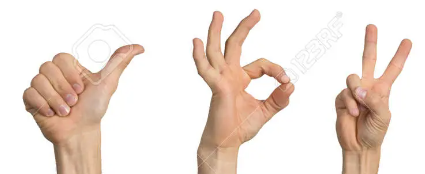